In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
#from xgboost import XGBClassifier
from sklearn import metrics
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score, classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# 3.1 - Understand the Industry

## 1. Explain the money flow and the information flow in the acquirer market and the role of the main players.

O fluxo de dinheiro no mercado de adquirência é o seguinte: Basicamente, um cliente chega em sua loja, faz uma compra utilizando seu cartão e, na hora de pagar, a maquininha da adquirente envia os dados do pedido de compra para a “bandeira” do cartão, solicitando que a transação seja autorizada. A bandeira, por sua vez, envia uma mensagem para o banco emissor do cartão, verificando se a autorização poderá ser aceita ou não. Durante essa verificação será feita a análise da senha digitada pelo cliente, e também se existe saldo ou crédito suficiente para transação. Caso não haja problemas, o banco emissor dará permissão para a bandeira, autorizando o pagamento do cliente. Após isso,  Quando a compra é autorizada, a adquirente envia as informações da transferência novamente à bandeira do cartão, que a envia ao banco, e esse repassa o valor da transação para a empresa adquirente, que fica  responsável por receber o dinheiro do banco e repassar ao comerciante no prazo combinado. 

* <font size="3">  Fluxo de informação: Informação da compra do cliente -> Empresa adquirente -> Bandeira do cartão/Banco -> Informação da permissão para a adquirente -> Compra aprovada (Adquirente) -> Bandeira cartão/banco.

Após o banco receber a confirmação da transferência, o fluxo do dinheiro é:

* <font size="3">  Banco -> Adquirente -> comerciante (prazo estipulado pelo contrato).

## 2. Explain the difference between acquirer, sub-acquirer and payment gateway and how the flow explained in question 1 changes for these players.

* Um Acquirer é uma empresa responsável por liquidar as transações financeiras por meio de cartão de crétido e débito. Empresas adquirentes, também chamadas de credenciadores, são as responsáveis pelo processamento das operações de cartão de crédito e débito. Sua principal função é criar um canal de comunicação rápido e seguro entre sua loja e o banco para checar os dados do consumidor e validar a compra.

* A subadquirente é uma empresa responsável por intermediar os pagamentos entre a loja e a adquirente. Ela é habilitada pelas adquirentes para realizar a conexão entre os clientes, os lojistas, bandeiras e bancos emissores. Uma das diferenças da adquirente é que ela consegue apresentar uma solução mais completa que uma adquirente, com anti-fraude e com burocracias menores do que se o lojista quiser se conectar diretamente com a adquirente, diminuindo ou até removendo a necessidade da relação do lojista e de um banco.

* O Gateway é uma ferramenta que pode ser considerada como um terminal de cartão de crédito para e-commerce. Da mesma forma que as maquininhas de cartão são para as lojas físicas. Os gateways são uma especie de HUB de funcionalidades, plataformas que são responsáveis por te conectar com todos os outros players, como empresas especializadas em anti-fraude , multi meios de pagamentos, etc. Uma loja de e-commerce, por exemplo, pode oferecer o serviço de todos os adquirentes sem precisar negociar com cada um deles, ou ter que integrar sua tecnologia com cada um deles. Eles processam informações para cobrança, as criptografam e enviam para as adquirentes fazer o serviço, após isso, o gateway repassa a confirmação para a loja.

Principais diferenças:

A empresa adquirente é responsável por criar um canal de comunicação rápido e seguro entre a loja onde está sendo efetuada a compra e o banco para checar os dados do consumidor e validar a compra, como explicado no item 1. Já a subadquirente, é uma empresa considerada intermediadora do meio de pagamento, ela irá intermediar a compra entre o lojista e a empresa adquirente. Em relação a uma empresa adquirente, a subadquirente consegue ser contratada de forma menos burocrática, consegue oferecer um pacote maior de funcionalidades, como por exemplo, anti fraude, algo que se o lojista quiser obter e utilizar uma empresa adquirente, ele terá que contratar a parte. Já o gateway, é utilizado em sites de vendas online, ele fornece uma intermediação entre o consumidor, o banco e as bandeiras de cartão. Com ele, é possível conectar o seu negócio a diferentes adquirentes (como se fossem as _'maquininhas de cartão'_ digitais) e manter centralizada toda a operação de pagamentos do seu negócio.


A diferença no fluxo de informação apresentados no item 1 quando estamos falando da utilização de uma subadquirente no lugar de uma adquirente é que, a subadquirente entrará no meio do fluxo entre o lojista e a adquirente, e será a responsável por passar as informações da compra para a adquirente e, depois da compra aprovada, realizar o pagamento ao lojista, como se fosse um passo a mais" no fluxo explicado anteriormente. Já o gateway, funciona como um intermediador de pagamento online, recebendo a informação da compra e passando para a empresa adquirente ou subadquirente de contrato do lojista, que, por sua vez, seguirá o fluxo explicado anteriormente, até o pagamento por parte da adquirente ou subadquirente contratada pelo comércio.

* <font size="3">  Diferenças: 
    * <font size="3">  Subadquirente: 
        * Uma "etapa a mais" no fluxo de informação na relação entre o lojista e a adquirente;
        * Menos burocracia na contratação do lojista;
        * Pacote maior de funcionalidades (por exemplo, antifraude);
        * Taxas maiores do que se o lojista contratar uma adquirente;
        * Está presente no fluxo de informação e de dinheiro.
    * <font size="3">  Gateway:
       * É um terminal de compra por cartão para ecommerce;
       * Processa as compras no checkout do site, criptografa a transação e envia para a adquirente;
       * Fornece tudo que o cliente precisa no site do ecommerce;
       * Oferece antifraude separadamente;
       * Está presente apenas no envio de informação para a adquirente (ou subadquirente) contratada pelo lojista, não participa do fluxo de dinheiro.
        
        

## 3. Explain what chargebacks are, how they differ from cancellations and what is their connection with fraud in the acquiring world.

O chargeback é a cobrança indevida. Acontece quando a pessoa vê a cobrança em seu cartão, mas não foi ela quem realizou a compra, ou em alguns casos, ela realizou a compra com o próprio cartão e pediu cancelamento pro banco. Nesse caso, o cliente vai ao banco contestar, e a instituição financeira cancela a transação.

Já o cancelamento é quando o cliente pede o cancelamento da compra junto à loja em que ele efetuou a compra, por algum motivo, devolvendo o produto de forma amigável, seja por defeito ou arrependimento.

Os chargebacks, em sua maioria, são realizados por causa de cartões clonados que são utilizados por fraudadores em compras, e estas são canceladas pelo dono real do cartão junto à instituição financeira. Neste caso, se configura uma fraude, e o banco, então, entra em contato com o adquirente que processou o pagamento para o comércio em questão com a ajuda da bandeira, que aciona a empresa envolvida, informando-a sobre o chargeback e cobrando a quantia que deve ser devolvida ao consumidor.


# 3.2 - Get your hands dirty

## 1. Analyze the data provided and present your conclusions (consider that all transactions are made using a mobile device).

In [4]:
dados = pd.read_csv('transactional-sample.csv')
print(dados.shape)

(3199, 8)


In [5]:
dados.head(10)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False
5,21320403,59566,40759,516292******8220,2019-12-01T21:25:53.374213,60.49,192705.0,False
6,21320404,20917,25661,650485******9310,2019-12-01T21:25:19.532243,318.37,760932.0,False
7,21320405,56107,81152,650516******9201,2019-12-01T21:24:05.608374,188.68,486.0,True
8,21320406,56107,81152,650516******9201,2019-12-01T21:13:21.529999,352.77,486.0,True
9,21320407,56107,81152,650516******9201,2019-12-01T21:04:55.066909,345.68,486.0,True


## Checando valores faltantes nos dados

In [6]:
dados.isnull().mean().sort_values(ascending = False)

device_id             0.259456
transaction_id        0.000000
merchant_id           0.000000
user_id               0.000000
card_number           0.000000
transaction_date      0.000000
transaction_amount    0.000000
has_cbk               0.000000
dtype: float64

Há valores faltantes apenas na variável _device_id_, da forma que eu a utilizarei na solução do problema, estes valores faltantes não serão um problema. 

##  Eliminando variável do ID da transação.

In [7]:
dados = dados.drop('transaction_id',axis = 1)

##  Passando variável _'transaction_date'_ para o tipo data.

In [8]:
dados['transaction_date'] = pd.to_datetime(dados['transaction_date'], format='%Y-%m-%dT%H:%M:%S.%f')
type(dados['transaction_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

## Transformação das variáveis

In [9]:
dados = dados.fillna(0)
dados = dados.astype({'device_id': 'int'})

# Análise descritiva.

## Verificando desbalanceamento da variável resposta.

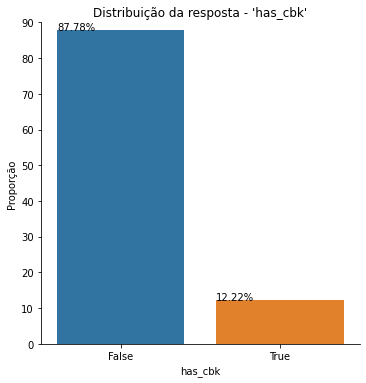

False    2808
True      391
Name: has_cbk, dtype: int64


In [17]:
x,y = 'index', 'has_cbk'

df1 = dados[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',kind='bar',data=df1)
g.ax.set_ylim(0,90)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    
plt.title("Distribuição da resposta - 'has_cbk'")
plt.xlabel("has_cbk")
plt.ylabel("Proporção")
plt.show()
chargeback_ratio = dados['has_cbk'].value_counts()
print(chargeback_ratio)
chargeback_ratio = chargeback_ratio[1] / chargeback_ratio.sum()

Temos uma boa diferença em relação a valores verdadeiros e falsos, o que já era esperado devido ao tipo do problema.

##  Variável _'transaction_amount'_

In [8]:
dados['transaction_amount'].describe()

count    3199.000000
mean      767.812904
std       889.095904
min         1.220000
25%       205.235000
50%       415.940000
75%       981.680000
max      4097.210000
Name: transaction_amount, dtype: float64

<AxesSubplot:xlabel='transaction_amount', ylabel='Count'>

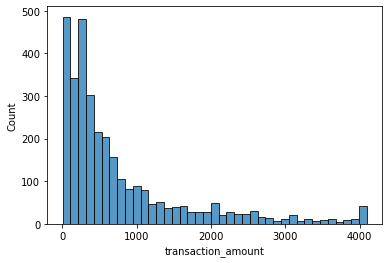

In [19]:
sns.histplot(dados['transaction_amount'])

* Temos uma distribuição assimétrica positiva, com sua maior parte dos valores concentrados em valores abaixo de 1000.

### Relação variável _'transaction_amount'_ com a variável resposta.

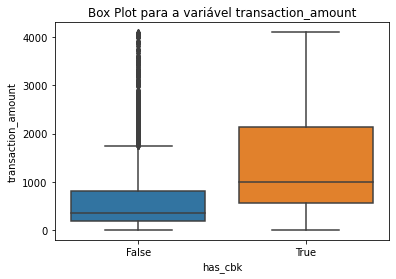

In [20]:
sns.boxplot(x = dados["has_cbk"], y = dados['transaction_amount'])
plt.title("Box Plot para a variável transaction_amount")
plt.show()

* A distribuição da variável _transaction_amount_ em relação à transaçoes fraudulentas possui valores maiores do que para as transações não fraudulentas.

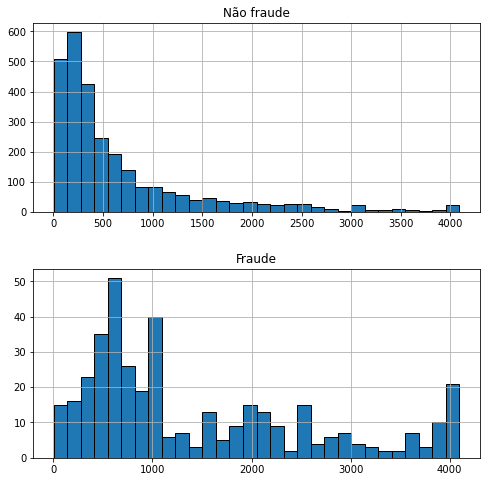

In [21]:
fig, ax = plt.subplots(2, figsize=(8,8))
dados.loc[dados["has_cbk"] == 0]["transaction_amount"].hist(bins=30, ax=ax[0],edgecolor='black')
dados.loc[dados["has_cbk"] == 1]["transaction_amount"].hist(bins=30, ax=ax[1],edgecolor='black')
ax[0].title.set_text("Não fraude")
ax[1].title.set_text("Fraude")
plt.subplots_adjust(hspace=0.3)

Temos uma grande diferença na distribuição das observações considerando cada variável resposta. Transações que não são fraude tendem a possuir valores concentrados abaixo de 1000, com alguns poucos mais altos. Já transações que são fraude possuem uma distribuição muito mais dispersa e sem padrão.

##  Variável _'transaction_date'_

In [31]:
print("Observação mais antiga da base de dados: ", min(dados['transaction_date']))
print("Observação mais recente da base de dados: ", max(dados['transaction_date']))   

Observação mais antiga da base de dados:  2019-11-01 01:27:15.811098
Observação mais recente da base de dados:  2019-12-01 23:16:32.812632


A base possui dados de transações no período de um mês, indo do início de novembro de 2019 ao início de dezembro de 2019

### Relação variável 'transaction_date' com a variável resposta.

### Hora

In [10]:
dados['transaction_date_hour'] = dados['transaction_date'].dt.hour #Criando uma variável numérica só com as horas.

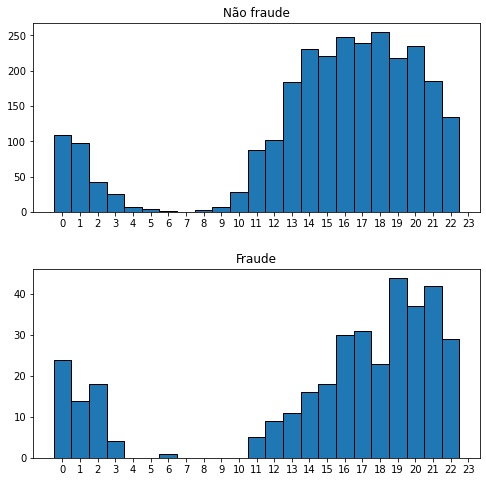

In [23]:
fig, ax = plt.subplots(2, figsize=(8,8))
for a in ax:
    a.set_xticks(range(24))
dados.loc[dados["has_cbk"] == 0]["transaction_date_hour"].hist(bins=np.arange(24)-0.5, ax=ax[0], grid=False,edgecolor='black')
dados.loc[dados["has_cbk"] == 1]["transaction_date_hour"].hist(bins=np.arange(24)-0.5, ax=ax[1], grid=False,edgecolor='black')
ax[0].title.set_text("Não fraude")
ax[1].title.set_text("Fraude")
plt.subplots_adjust(hspace=0.3)

Podemos ver que o pico de transação fraudulenta ocorre entre 19:00h e 22:00h. Já em relação as transações legítimas, há um pico de transações muito mais suave, entre as 14:00h e 20:00h.

### Dia do mês

In [11]:
dados['transaction_month_day'] = dados['transaction_date'].dt.day #Criando uma variável numérica com os dias do mês.

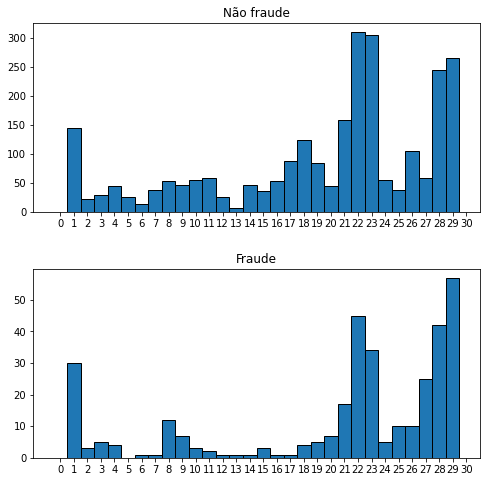

In [32]:
fig, ax = plt.subplots(2, figsize=(8,8))
for a in ax:
    a.set_xticks(range(31))
dados.loc[dados["has_cbk"] == 0]['transaction_month_day'].hist(bins=np.arange(31)-0.5, ax=ax[0], grid=False,edgecolor='black')
dados.loc[dados["has_cbk"] == 1]['transaction_month_day'].hist(bins=np.arange(31)-0.5, ax=ax[1], grid=False,edgecolor='black')
ax[0].title.set_text("Não fraude")
ax[1].title.set_text("Fraude")
plt.subplots_adjust(hspace=0.3)

Dada a granularidade da informação (dias do mês) e o fato de não termos muitos dados, a figura acima não nos fornece nenhuma informação relevante.

### Dia da semana.

In [12]:
dados['transaction_week_day'] = dados['transaction_date'].dt.dayofweek   #Criando uma variável numérica só com os respectivos dias da semana.
#0 é segunda, 1 é terça e assim por diante.

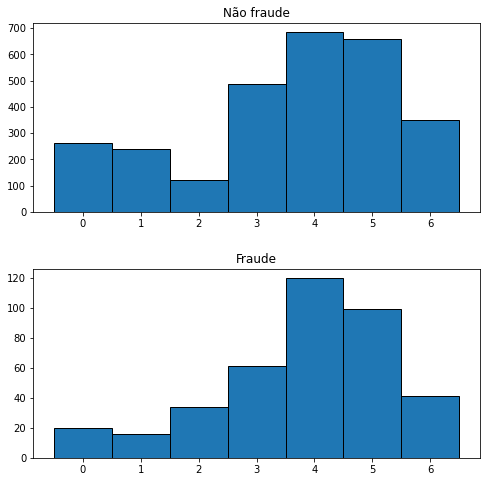

In [13]:
fig, ax = plt.subplots(2, figsize=(8,8))
for a in ax:
    a.set_xticks(range(8))
dados.loc[dados["has_cbk"] == 0]['transaction_week_day'].hist(bins=np.arange(8)-0.5, ax=ax[0], grid=False,edgecolor='black')
dados.loc[dados["has_cbk"] == 1]['transaction_week_day'].hist(bins=np.arange(8)-0.5, ax=ax[1], grid=False,edgecolor='black')
ax[0].title.set_text("Não fraude")
ax[1].title.set_text("Fraude")
plt.subplots_adjust(hspace=0.3)

Vemos uma diferença na distribuição da variável respectiva ao número de fraude, indicando que nos primeiros dias da semana, temos um número de fraudes menor do que de transações verdadeiras.

## Variáveis ID's e cartão de crédito.

#### Antifraud Requirements:
* Reject transaction if user is trying too many transactions in a row;
* Reject transactions above a certain amount in a given period;
* Reject transaction if a user had a chargeback before (note that this information does not comes on the payload. The chargeback data is received days after the transaction was approved)

Após pensar no problema e de acordo com os requerimentos do sistema anti-fraude listados acima, estas variáveis serão variáveis elegíveis para a parte rule-based da minha solução, enquanto que as variáveis _transaction_date_hour_ e _transaction_amount_, serão utilizadas em uma abordagem de machine-learning.

Sendo assim, como um dos requerimentos é bloquear uma transação de um usuário se ele já realizou um chargeback antes, eu vou querer saber se as variáveis _device_id_, '_card_number_' e '_merchant_id_' possuem características semelhantes à variável _user_id_, pois se sim, posso incluí-las na parte rule-based do meu detector de fraude.

### Proporção de valores únicos que aparecem tanto em transações fraudulentas como não fraudulentas.

In [14]:
dados_true = dados.loc[dados['has_cbk'] == True,:]
dados_false = dados.loc[dados['has_cbk'] == False,:]

In [114]:
def prop(variavel,dados_false,dados_true):
    unq = list(pd.unique(dados_true[variavel])) #Extraindo valores únicos da coluna da variável do conjunto só de fraudes
    lst = list(pd.unique(dados_false[variavel])) #Extraindo valores únicos da coluna da variável do conjunto só de legítimas
    nos_dois = []
    for i in unq: #para cada valor na lista de valores únicos do conjunto de fraude
        if i in lst: #se o valor estiver na lista de valores únicos de transações legítimas,
            nos_dois.append(i) #Adiciono esse valor na lista.
    return print(100*round(len(nos_dois)/len(unq),4),'%') #Retorno a porcentagem de valores que estão tanto no conjunto 
                                                          #só de fraudes como no conjunto só de legítimas.

#### _'user_id'_

In [148]:
prop(variavel = 'user_id',dados_false = dados_false,dados_true = dados_true)

21.57 %


#### _'device_id'_

In [132]:
prop(variavel = 'device_id',dados_false = dados_false,dados_true = dados_true)

20.77 %


#### _'card_number'_

In [146]:
prop(variavel = 'card_number',dados_false = dados_false,dados_true = dados_true)

2.55 %


#### _'merchant_id'_

In [147]:
prop(variavel = 'merchant_id',dados_false = dados_false,dados_true = dados_true)

44.07 %


A variável _'user_id'_, possui 21.74% de suas observações que são fraude também em observações que não são fraude. Ou seja, 21.57% dos usuários que já foram responsáveis por uma transação fraude, também foram responsáveis por pelo menos uma transação não fraudulenta. 

As variáveis _'device_id'_ e _'card_number'_ possuem essa porcentagem menor, sendo a _'card_number'_ a menor de todas. O que me faz decidir utilizar essas variáveis como decisivas na hora de detectar se uma transação será fraude ou não, da mesma maneira que a variável _'user_id'_ será utilizada. Já para a variável _'merchant_id'_, levando em conta a lógica e meu entendimento do negócio e também por ela possuir uma porcentagem muito maior que a variável _'user_id'_, não a utilizarei desta maneira.

### Relação valores faltantes da variável _'device_id'_ com variável resposta.

In [115]:
print('Poporção de valores faltantes dos dados só de transações legítimas: ',dados_false['device_id'].isnull().mean())

Poporção de valores faltantes dos dados só de transações legítimas:  0.27172364672364674


In [116]:
print('Poporção de valores faltantes dos dados só de transações fraude: ',dados_true['device_id'].isnull().mean())

Poporção de valores faltantes dos dados só de transações fraude:  0.17135549872122763


Não temos uma relação significativa para utilizar este tipo de informação

## Principais conclusões

* Pico de transações fraudulentas é entre 19:00h e 22:00h;
* A maior parte das transações não fraudulentas ocorrem a um valor abaixo de 100;
* A maior parte das transações acontecem na quinta-feira, sexta-feira e sábado;
* Sem um padrão em relação ao valor da transação para as compras que são fraude;
* Número de vezes que um cartão de crédito e que um dispositivo específico é detectado tanto em transações fraudulentas como não fraudulentas é menor que o de usuários específicos, o que indica que estas variáveis podem discriminar uma transação fraude tão bem quanto o id do usuário.





## 2. In addition to the spreadsheet data, what other data would you look at to try to find patterns of possible frauds?

* IP em que o dispositivo estava conectado na hora da compra:
* Variáveis baseadas em geolocalização, como distância de onde a compra foi feita ao endereço cadastrado do usuário:
* Informação prévia do perfil de compra do usuário, que pode ser útil para identificar uma transação fraude.


# 3.3 - Solve the problem

## Machine Learning

### Divisão conjunto de dados em treino/validação e teste.

In [17]:
trainDF, testDF = train_test_split(dados.loc[:,['transaction_amount','transaction_date_hour','transaction_week_day',
                                                'transaction_month_day','has_cbk']], test_size=0.20, random_state=42, stratify=dados[['has_cbk']])

In [18]:
X_train = np.array(trainDF.iloc[:,:-1])
y_train = np.array(trainDF.iloc[:,-1])
y_train = np.multiply(y_train, 1)
X_test = np.array(testDF.iloc[:,:-1])
y_test = np.array(testDF.iloc[:,-1])
y_test = np.multiply(y_test, 1)

## Classificação sem método balanceamento dos dados.

Primeiramente, vou avaliar alguns modelos estatísticos sem utilizar nenhuma técnica de resempling para balanceamento dos dados, apenas utilizando o hiperparâmetro _'class_weight'_ na busca de melhores parâmetros, cabendo a validação cruzada decidir se este método de lidar com balanceamento produz ou não melhores resultados quando comparado ao modelo sem ele.

In [500]:
def classification_nested_crossvalidation(X, y,n_folds,k_folds,model,hp_grid,scale):
    # Definindo as pastas de validação externas
    cv_outer = StratifiedKFold(n_folds, shuffle=True)
    vacc = list()
    # CV loop externo
    for train_out, test_out in cv_outer.split(X,y):
        train_x, train_y = X[train_out], y[train_out]
        test_x, test_y = X[test_out], y[test_out]
        if scale == True:                
            scaler = StandardScaler().fit(train_x)
            train_x_transformed = scaler.transform(train_x)
            test_x_transformed = scaler.transform(test_x)
            #CV interno (training and validation sets)
            grid_search_cv = GridSearchCV(model, hp_grid, cv=k_folds, refit=True,scoring="roc_auc",n_jobs =-1)
            # Achando os melhores hiperparâmetros
            result = grid_search_cv.fit(train_x_transformed, train_y)
            best_model = result.best_estimator_
            # Predizendo no conjunto de validação
            pred_y = best_model.predict(test_x_transformed)            
            vacc.append(roc_auc_score(test_y, pred_y))
        else:
            #CV interno (training and validation sets)
            grid_search_cv = GridSearchCV(model, hp_grid, cv=k_folds, refit=True,scoring="roc_auc",n_jobs =-1)
            # Achando os melhores hiperparâmetros
            result = grid_search_cv.fit(train_x, train_y)
            best_model = result.best_estimator_
            # Predizendo no conjunto de validação
            pred_y = best_model.predict(test_x)            
            vacc.append(roc_auc_score(test_y, pred_y))
    return print("Média das AUC's das folds de validação: ",np.mean(vacc),
                 "Desvio padrão das AUC's das folds de validação: ", np.std(vacc))

#### Random Forest

In [53]:
params_RF = {'n_estimators': [50, 150, 250],
            'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
            'min_samples_split': [2, 4, 6],
            'class_weight': [None, 'balanced']}

model_RF = RandomForestClassifier(n_jobs =-1)

In [54]:
classification_nested_crossvalidation(X=X_train,y=y_train,n_folds=5,k_folds=3, model=model_RF,hp_grid=params_RF,scale = False)

Média das AUC's das folds de validação:  0.6374433243727599 Desvio padrão das AUC's das folds de validação:  0.043991177267334466


### XGboost

In [501]:
params_XGB = {
        "gamma":[0.5, 1, 1.5, 2, 5],
        "max_depth":[3,4,5,6],
        "min_child_weight": [100],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "learning_rate": [0.1, 0.01, 0.001],
    }
model_XGB = XGBClassifier(eval_metric="auc",use_label_encoder=False,n_jobs =-1)

In [502]:
classification_nested_crossvalidation(X=X_train,y=y_train,n_folds=5,k_folds=2, model=model_XGB,hp_grid=params_XGB,scale = False)

Média das AUC's das folds de validação:  0.5 Desvio padrão das AUC's das folds de validação:  0.0


### KNN

In [503]:
params_KNN = {
        "n_neighbors":[3,5,7,10,15,20,25,30,100],
        "weights":['uniform','distance'],
        "metric": ['euclidean','manhattan','minkowski','chebyshev'],
    }
model_KNN = KNeighborsClassifier()

In [504]:
classification_nested_crossvalidation(X=X_train,y=y_train,n_folds=5,k_folds=2, model=model_KNN,hp_grid=params_KNN,scale = True)

Média das AUC's das folds de validação:  0.5302500772610694 Desvio padrão das AUC's das folds de validação:  0.011141195453011319


## Classificação com método balanceamento dos dados (SMOTE).

In [19]:
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(X_train, y_train)

In [20]:
df_SMOTE = pd.DataFrame(X_train_smote, columns = ['transaction_amount','transaction_date_hour','transaction_week_day',
                                                'transaction_month_day',])
df_SMOTE['has_cbk'] = y_train_smote

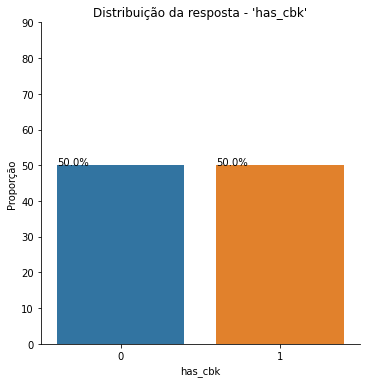

0    2246
1    2246
Name: has_cbk, dtype: int64


In [21]:
x,y = 'index', 'has_cbk'

df1 = df_SMOTE[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',kind='bar',data=df1)
g.ax.set_ylim(0,90)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    
plt.title("Distribuição da resposta - 'has_cbk'")
plt.xlabel("has_cbk")
plt.ylabel("Proporção")
plt.show()
chargeback_ratio = df_SMOTE['has_cbk'].value_counts()
print(chargeback_ratio)
chargeback_ratio = chargeback_ratio[1] / chargeback_ratio.sum()

#### Random Forest

In [508]:
params_RF = {'n_estimators': [50, 150, 250],
            'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
            'min_samples_split': [2, 4, 6],
            'class_weight': [None, 'balanced']}

model_RF = RandomForestClassifier(n_jobs =-1)

In [514]:
classification_nested_crossvalidation(X=X_train_smote,y=y_train_smote,n_folds=10,k_folds=5, model=model_RF,hp_grid=params_RF,scale = False)

Média das AUC's das folds de validação:  0.9222996031746031 Desvio padrão das AUC's das folds de validação:  0.01480650278502158


### XGboost

In [510]:
params_XGB = {
        "gamma":[0.5, 1, 1.5, 2, 5],
        "max_depth":[3,4,5,6],
        "min_child_weight": [100],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "learning_rate": [0.1, 0.01, 0.001],
    }
model_XGB = XGBClassifier(eval_metric="auc",use_label_encoder=False,n_jobs =-1)

In [511]:
classification_nested_crossvalidation(X=X_train_smote,y=y_train_smote,n_folds=5,k_folds=3, model=model_XGB,hp_grid=params_XGB,scale = False)

Média das AUC's das folds de validação:  0.8203449641177928 Desvio padrão das AUC's das folds de validação:  0.01537927919946505


### KNN

In [512]:
params_KNN = {
        "n_neighbors":[3,5,7,10,15,20,25,30],
        "weights":['uniform','distance'],
        "metric": ['euclidean','manhattan','minkowski','chebyshev'],
    }
model_KNN = KNeighborsClassifier()

In [513]:
classification_nested_crossvalidation(X=X_train_smote,y=y_train_smote,n_folds=5,k_folds=3, model=model_KNN,hp_grid=params_KNN,scale = True)

Média das AUC's das folds de validação:  0.8693254145013609 Desvio padrão das AUC's das folds de validação:  0.00555472461129147


Temos que a melhor AUC obtida foi utilizando o modelo Random Forest, então, este modelo será o utilizado para seguirmos com a parte de Machine-Learning.

## Avaliação modelo final.

##### Vamos então utilizar o algorítmo de Ensamble Random Forests nos dados balanceados para realizar a classificação dos nossos dados.

Encontrando melhores hiperparâmetros para os dados de treino.

In [515]:
params_RF = {'n_estimators': [50, 150, 250],
            'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
            'min_samples_split': [2, 4, 6],
            'class_weight': [None, 'balanced']}

model_RF = RandomForestClassifier(n_jobs=-1)

In [516]:
grid_search_cv = GridSearchCV(model_RF, params_RF, cv=10,scoring="roc_auc",n_jobs=8)
# Achando os melhores hiperparâmetros
result = grid_search_cv.fit(X_train_smote, y_train_smote)
best_model = result.best_estimator_
best_model

RandomForestClassifier(max_features=0.25, min_samples_split=4, n_estimators=250,
                       n_jobs=-1)

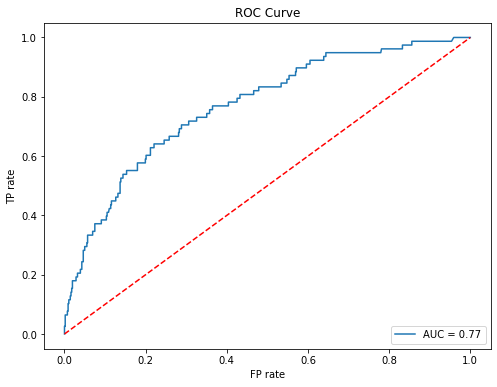

In [518]:
y_pred = best_model.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

Vamos calcular o ponto de corte que possui o melhor balanço entre verdadeiro positivo e falso positivo.

In [520]:
t_opt_idx = np.argmax(tp_r - fp_r)
t_opt = t[t_opt_idx]
print("Threshold value is: %.2f" % t_opt)

Threshold value is: 0.23


Utilizando o ponto de corte escolhido para a classificação final, temos:

In [543]:
predict_probab = best_model.predict_proba(X_test)[:,1]
y_pred = np.where(predict_probab > 0.23, 1, 0)

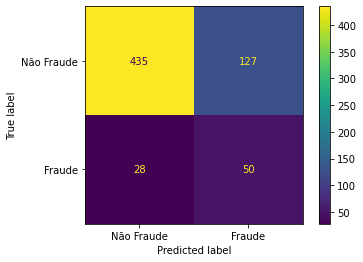

In [552]:
labels = ['Não Fraude', 'Fraude']
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

Embora este seja o melhor cenário para a métrica AUC, que procura o melhor balanço entre verdadeiro positivo e falso positivo, pode não ser o melhot cenário para o contexto de fraude. Sendo assim, deve-se realizar um estudo para determinar o ponto de corte ideal de acordo com as preferências do negócio.

# Dector de fraude.

In [127]:
df_guardar = pd.DataFrame(columns = ['transaction_id','merchant_id','user_id','card_number','transaction_date','transaction_amount','device_id'])

def detectar_fraude(transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id):
    
    data = [[transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id]]
    
    df = pd.DataFrame(data, columns = ['transaction_id','merchant_id','user_id','card_number',
                                       'transaction_date','transaction_amount','device_id'])
    
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%Y-%m-%dT%H:%M:%S.%f')
    df['transaction_date_hour'] = df['transaction_date'].dt.hour
    df['transaction_month_day'] = df['transaction_date'].dt.day
    df['transaction_week_day'] = df['transaction_date'].dt.dayofweek
    

    
    global df_guardar #Tabela onde serão guardadas as tentativas de compra.
    
    df_guardar = df_guardar.append(df,ignore_index=True)
    
    df_guardar['transaction_date'] = pd.to_datetime(df_guardar['transaction_date'], format='%Y-%m-%dT%H:%M:%S.%f')
    
    df_guardar['user_id'] = pd.to_numeric(df_guardar['user_id'])
    df_guardar['merchant_id'] = pd.to_numeric(df_guardar['merchant_id'])
    df_guardar['device_id'] = pd.to_numeric(df_guardar['device_id'])
    df_guardar['transaction_id'] = pd.to_numeric(df_guardar['transaction_id'])
    
    
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%dT%H:%M:%S.%f")
    current_time = pd.to_datetime(current_time, format='%Y-%m-%dT%H:%M:%S.%f')
    current_time_less_1 = current_time - timedelta(hours=1)
    
    #Based-Rule:
    if user_id in dados_true['user_id'].values:
        print("'transaction_id' :", transaction_id,
                " \n'recommendation' : Negado pois usuário já possui uma transação fraude anterior.")
        
    elif card_number in dados_true['card_number'].values:
        print("'transaction_id' :", transaction_id,
                " \n'recommendation' : Negado pois cartão já foi utilizado em uma transação fraude anterior.")
        
    elif device_id in dados_true['device_id'].values:
        print("'transaction_id' :", transaction_id,
                " \n'recommendation' : Negado pois o dispositivo utilizado já foi utilizado em uma transação fraude anterior.")     
    
    elif (sum((df_guardar.transaction_date < current_time) & (df_guardar.transaction_date > current_time_less_1) & (df_guardar.user_id == user_id)) !=0):
        
        if df_guardar.loc[(df_guardar.transaction_date < current_time) & (df_guardar.transaction_date > current_time_less_1) & (df_guardar.user_id == user_id),'user_id'].value_counts()[user_id] > 5:
            print("'transaction_id' :", transaction_id,
                " \n'recommendation' : Negado pois o usuário tentou comprar mais de 5 vezes consecutivas na última hora.")
        else:

            model = RandomForestClassifier(max_features=0.25, min_samples_split=4, n_estimators=250,n_jobs=-1)
            model.fit(X_train_smote, y_train_smote)
            predict_probabilities = model.predict_proba(np.array(df[['transaction_amount','transaction_date_hour',
                                                                     'transaction_week_day','transaction_month_day']]))[:,1]       
            y_pred = np.where(predict_probabilities > 0.23, 1, 0)

            if int(y_pred) == 1:
                print("'transaction_id' :", transaction_id,
                    "\n'recommendation' : Negado pelo modelo de Machine Learning.")
            else:
                print("'transaction_id' :", transaction_id,
                    " \n'recommendation' : Aprovado pelo modelo de Machine Learning.")

## Testando detector

In [52]:
dados_true

,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,transaction_date_hour,transaction_month_day,transaction_week_day
1,92895,2708,444456******4210,2019-12-01 22:45:37.873639,734.87,497105,True,22,1,6
3,68657,69758,464296******3991,2019-12-01 21:59:19.797129,2556.13,0,True,21,1,6
7,56107,81152,650516******9201,2019-12-01 21:24:05.608374,188.68,486,True,21,1,6
8,56107,81152,650516******9201,2019-12-01 21:13:21.529999,352.77,486,True,21,1,6
9,56107,81152,650516******9201,2019-12-01 21:04:55.066909,345.68,486,True,21,1,6
...,...,...,...,...,...,...,...,...,...,...
3157,41354,19820,606282******6581,2019-11-02 18:04:22.088172,4028.55,0,True,18,2,5
3165,41354,19820,606282******6581,2019-11-02 16:33:21.333131,4031.00,0,True,16,2,5
3178,16266,96495,522840******2045,2019-11-01 22:10:49.517024,762.18,0,True,22,1,4
3180,16266,96495,552305******4782,2019-11-01 20:54:04.014855,2936.66,0,True,20,1,4


### Usuário com transação fraude anterior.

In [129]:
detectar_fraude(transaction_id=9289225,merchant_id=92895 ,user_id=2708,card_number='44456******4210',transaction_date='2021-12-07T08:50:50.812632',transaction_amount=20,device_id=47105)

'transaction_id' : 9289225  
'recommendation' : Negado pois usuário já possui uma transação fraude anterior.


### Celular com transação fraude anterior.

In [130]:
detectar_fraude(transaction_id=9289225,merchant_id=92895 ,user_id=27208,card_number='464296******3491',transaction_date='2021-12-07T08:50:50.812632',transaction_amount=20,device_id=486)

'transaction_id' : 9289225  
'recommendation' : Negado pois o dispositivo utilizado já foi utilizado em uma transação fraude anterior.


### Cartão com transação fraude anterior.

In [110]:
detectar_fraude(transaction_id=9289225,merchant_id=92895 ,user_id=27208,card_number='444456******4210',transaction_date='2021-12-07T08:50:50.812632',transaction_amount=20,device_id=4896)

'transaction_id' : 9289225  
'recommendation' : Negado pois cartão já foi utilizado em uma transação fraude anterior.


### Multiplas tentativas

In [131]:
c = 0
for i in range(1,7):
    c=c+1
    print('Tentativa ',c)
    detectar_fraude(transaction_id=9289225,merchant_id=92895 ,user_id=708,card_number='44445******4210',transaction_date='2021-12-07T13:20:50.812632',transaction_amount=20,device_id=4896)


Tentativa  1
'transaction_id' : 9289225  
'recommendation' : Aprovado pelo modelo de Machine Learning.
Tentativa  2
'transaction_id' : 9289225  
'recommendation' : Aprovado pelo modelo de Machine Learning.
Tentativa  3
'transaction_id' : 9289225  
'recommendation' : Aprovado pelo modelo de Machine Learning.
Tentativa  4
'transaction_id' : 9289225  
'recommendation' : Aprovado pelo modelo de Machine Learning.
Tentativa  5
'transaction_id' : 9289225  
'recommendation' : Aprovado pelo modelo de Machine Learning.
Tentativa  6
'transaction_id' : 9289225  
'recommendation' : Negado pois o usuário tentou comprar mais de 5 vezes consecutivas na última hora.


### Machine Learning

In [143]:
detectar_fraude(transaction_id=9289225,merchant_id=92895 ,user_id=78908,card_number='44445******4210',transaction_date='2021-12-07T13:20:50.812632',transaction_amount=20,device_id=4896)

'transaction_id' : 9289225  
'recommendation' : Aprovado pelo modelo de Machine Learning.
